# **k-Nearest Neighbors**
The k-Nearest Neighbors algorithm or KNN for short is a straightforward approach in which the entire training dataset is stored. When making predictions, the k-most similar records to a new record from the training dataset are identified. Various methods can be employed to measure similarity between records, with the Euclidean distance being a common choice for tabular data. After locating the neighbors, a summary prediction is derived by either returning the most frequent outcome or computing the average. Consequently, KNN can be applied to both classification and regression problems.


In this notebook, our initial steps involve data preparation, including the upload and normalization of the dataset. We proceed to implement k-NN from scratch as a preliminary measure. Following that, we determine the optimal value for k from a range of 30 values to achieve the highest accuracy. Subsequently, we explore a data reduction technique and assess the accuracy of 1-NN applied to both datasets. Additionally, we compare the time complexity of various algorithms that k-NN can employ to speed up distance calculations. Lastly, we investigate the impact of class imbalance on accuracy.

In [ ]:
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import neighbors as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# **1. Data Preparation**

**1.1. Uploading the dataset**

In [ ]:
# reading the waveform data file
data = pd.read_csv('waveform.data', header=None, sep=",")
data.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-1.23,-1.56,-1.75,-0.28,0.60,2.22,0.85,0.21,-0.20,0.89,...,2.89,7.75,4.59,3.15,5.12,3.32,1.20,0.24,-0.56,2
1,-0.69,2.43,0.61,2.08,2.30,3.25,5.52,4.55,2.97,2.22,...,1.24,1.89,1.88,-1.34,0.83,1.41,1.78,0.60,2.42,1
2,-0.12,-0.94,1.29,2.59,2.42,3.55,4.94,3.25,1.90,2.07,...,2.50,0.12,1.41,2.78,0.64,0.62,-0.01,-0.79,-0.12,0
3,0.86,0.29,2.19,-0.02,1.13,2.51,2.37,5.45,5.45,4.84,...,2.58,1.40,1.24,1.41,1.07,-1.43,2.84,-1.18,1.12,1
4,1.16,0.37,0.40,-0.59,2.66,1.00,2.69,4.06,5.34,3.53,...,4.30,1.84,1.73,0.21,-0.18,0.13,-0.21,-0.80,-0.68,1


**1.2. Normalizing the dataset**

Finding the minimum and maximum values for each column and rescaling the dataset columns to the range 0-1 is a common preprocessing step in machine learning, including k-nearest neighbors (KNN) algorithms. This process is known as feature scaling or normalization, and it serves several purposes:



> a. Equal Weighting of Features: KNN is a distance-based algorithm, and distances are sensitive to the scale of the features. Features with larger magnitudes might dominate the distance computations, leading to a biased influence on the model. Rescaling ensures that all features contribute equally to the distance calculations, preventing features with larger scales from having an undue influence.

> b. Improved Convergence: Many machine learning algorithms, including KNN, converge faster when features are on a similar scale. Normalizing features can lead to quicker convergence during the training process.

> c. Outlier Sensitivity: KNN can be sensitive to outliers. Rescaling helps mitigate the impact of outliers by bringing all data points to a similar scale, making the algorithm more robust.

> d. Distance Metrics: KNN relies on distance metrics (such as Euclidean distance) to determine the "closeness" of data points. Rescaling ensures that the distances are meaningful and not dominated by the scale of the features.

To normalize the data, we can use either the 'MinMaxScaler' from sickit-learn or build a function from scratch.


In [ ]:
# Using MinMaxScaler
columns_to_normalize = data.columns
data_normalized = data.copy()
scaler = MinMaxScaler()
data_normalized[columns_to_normalize] = scaler.fit_transform(data_normalized[columns_to_normalize])

In [ ]:
# Using a personal function
# Finding the min and max values for each column
def dataset_minmax(dataset):
  minmax = list()
  for i in range(len(dataset.columns)-1): # Considering all columns but the target
    col_values = dataset.iloc[:, i]  # Extracting all values from the i-th column
    value_min = col_values.min() # Finding the minimum value in the column
    value_max = col_values.max() # Finding the maximum value in the column
    minmax.append([value_min, value_max])
  return minmax

# Rescaling dataset columns to the range 0-1
def normalize_dataframe(dataset, minmax):
  for i in range(len(dataset.columns)-1): # Considering all columns but the target
    # Normalizes the value in the i-th column of the current row using the formula (value - min)/(max - min)
    dataset.iloc[:, i] = (dataset.iloc[:, i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])
  return dataset

# Applying the two functions on our dataset
minmax = dataset_minmax(data)
data_normalized = normalize_dataframe(data, minmax)
data_normalized.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.289835,0.237027,0.274664,0.371220,0.408818,0.479769,0.345199,0.328345,0.281915,0.284501,...,0.544016,1.000000,0.633865,0.565899,0.842718,0.719844,0.535308,0.463504,0.420786,2
1,0.364011,0.796634,0.539238,0.617310,0.579158,0.578998,0.731788,0.710387,0.562943,0.425690,...,0.380811,0.445601,0.393617,0.152074,0.426214,0.534047,0.601367,0.507299,0.798479,1
2,0.442308,0.323983,0.615471,0.670490,0.591182,0.607900,0.683775,0.595951,0.468085,0.409766,...,0.505440,0.278146,0.351950,0.531797,0.407767,0.457198,0.397494,0.338200,0.476553,0
3,0.576923,0.496494,0.716368,0.398332,0.461924,0.507707,0.471026,0.789613,0.782801,0.703822,...,0.513353,0.399243,0.336879,0.405530,0.449515,0.257782,0.722096,0.290754,0.633714,1
4,0.618132,0.507714,0.515695,0.338895,0.615230,0.362235,0.497517,0.667254,0.773050,0.564756,...,0.683482,0.440870,0.380319,0.294931,0.328155,0.409533,0.374715,0.336983,0.405577,1


In [ ]:
# Splitting the data
X = data_normalized.drop(21, axis=1)
y = data_normalized[21]

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2, random_state=42)

# Sets to be used in the personal functions
train_set = pd.concat([Xtrain, ytrain], axis=1)
test_set = pd.concat([Xtest, ytest], axis=1)

# **2. Building k-NN**

**2.1. Essential functions**



Step 1: Calculate The Distance.

Step 2: Get Nearest Neighbors.

Step 3: Make Predictions.

In [ ]:
# Calculating the distance between two rows from the dataset
def distance(row1, row2, p):
  distance = 0.0
  # We assume that the last column in each row is an output value (the target) which is ignored from the distance calculation
  for i in range(len(row1)-1):
    distance += np.abs(row1[i] - row2[i])**p
  return (distance ** (1/p))

In [ ]:
# Locating the most similar neighbors
def get_neighbors(train, new_data_point, num_neighbors, p):
  distances = list()

  # We iterate through each row in the training set
  for train_row_index, train_row in train.iterrows():
    # We calculate the distances between our new datapoint and each of the datapoints (the rows) in our dataset
    dist = distance(new_data_point.tolist(), train_row.tolist(), p)
    distances.append((train_row_index, dist))

  # We sort the distances in ascending order
  distances.sort(key=lambda tup: tup[1])
  nearest_neighbors = list()
  all_neighbors = list()
  # We retrieve the k nearest neighbors
  for i in range(num_neighbors):
    nearest_neighbors.append(distances[i][0])
  return nearest_neighbors

In [ ]:
# Making a classification prediction with neighbors
def predict_classification(train, new_data_point, num_neighbors, p):
  # We retreive the indices of the neighbors
  nearest_neighbors = get_neighbors(train, new_data_point, num_neighbors, p)
  output_values = train.loc[nearest_neighbors, 21].tolist()
  '''
  Given a list of class values observed in the neighbors,
  the max() function takes a set of unique class values
  and calls the count on the list of class values for each class value in the set.
  '''
  prediction = max(set(output_values), key=output_values.count)
  return prediction

In [ ]:
# Predicting the target value for test data points using the functions created
def k_nearest_neighbors(train, test, num_neighbors, p):
  predictions = list()
  for _, test_row in test.iterrows():
    output = predict_classification(train, test_row, num_neighbors, p)
    predictions.append(output)
  return(predictions)

**2.2. Testing the model**

In [ ]:
# Setting the hyperparameters
num_neighbors = 5
p = 2

# Testing the personal k-NN
start_time = timeit.default_timer()
predictions = k_nearest_neighbors(train_set, test_set, num_neighbors, p)
true_classes = test_set[21].tolist()
personal_knn_accuracy = accuracy_score(true_classes, predictions)
end_time = timeit.default_timer()
personal_knn_time = end_time - start_time

# Testing KNeighborsClassifier
start_time = timeit.default_timer()
clf = nn.KNeighborsClassifier(num_neighbors)
clf.fit(Xtrain, ytrain)
knn_classifier_accuracy = clf.score(Xtest,ytest)
end_time = timeit.default_timer()
knn_classifier_time = end_time - start_time

print("Comparing the two models in terms of accuracy:")
print('Accuracy of the personal k-NN: ', personal_knn_accuracy)
print('Accuracy of K Neighbors Classifier: ', knn_classifier_accuracy)
print("\n")
print("Comparing the two models in terms of time complexity:")
print('Time complexity of the personal k-NN: ', personal_knn_time)
print('Time complexity of K Neighbors Classifier: ', knn_classifier_time)

Comparing the two models in terms of accuracy:

Accuracy of the personal k-NN:  0.835
Accuracy of K Neighbors Classifier:  0.835


Comparing the two models in terms of time complexity:

Time complexity of the personal k-NN:  313.03717703999973
Time complexity of K Neighbors Classifier:  0.07841267600088031


The personal approach is similar to K Neighbors Classifier in terms of accuracy, but it takes more time. Thus, we will use the K Neighbors Classifier for the rest of project.

# **3. Tuning Hyperparameters**

The best accuracy reached  0.8542500000000001


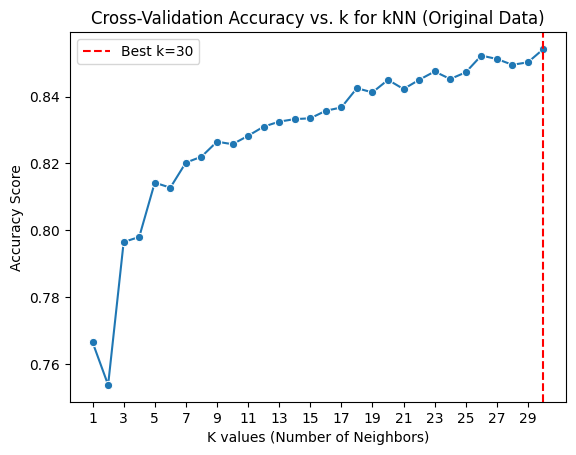

In [ ]:
# Tuning the number of neighbors
k_values = [i for i in range (1,31)]
scores = []

for k in k_values:
  clf = nn.KNeighborsClassifier(n_neighbors=k)
  score = cross_val_score(clf, Xtrain, ytrain, cv=5)
  scores.append(np.mean(score))

# Finding the k value with the maximum accuracy
best_k = k_values[np.argmax(scores)]

# Printing the maximum accuracy obtained
print("The best accuracy reached ", max(scores))

# Plotting
sns.lineplot(x=k_values, y=scores, marker='o')
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best k={best_k}')
plt.xlabel("K values (Number of Neighbors)")
plt.ylabel("Accuracy Score")
plt.title('Cross-Validation Accuracy vs. k for kNN (Original Data)')

# Setting x-axis ticks to include the best k value
plt.xticks(np.arange(min(k_values), max(k_values)+1, 2))
plt.legend()
plt.show()


One of the hyperparameters of k-NN is p, the power used in the norm to calculate distances. We can try implementting grid search to find the best combination (k,p) for which we get the best accuracy.

In [ ]:
from sklearn.model_selection import GridSearchCV
hyperparameters = {"n_neighbors":range(1,31), "p":range(1,6)}

grid_search = GridSearchCV(clf, hyperparameters, cv=5)
grid_search.fit(Xtrain, ytrain)

optimal_k = grid_search.best_params_["n_neighbors"]
optimal_p = grid_search.best_params_["p"]

print("Optimal number of neighbors is ", optimal_k)
print("Optimal distance measure is the measure we get using the power of ", optimal_p)

Optimal number of neighbors is  30
Optimal distance measure is the measure we get using the power of  2


In [ ]:
# Testing KNeighborsClassifier using the optimal (k,p)
clf = nn.KNeighborsClassifier(n_neighbors=optimal_k, p=optimal_p)
clf.fit(Xtrain, ytrain)

optimal_accuracy = clf.score(Xtest, ytest)
print("Accuracy KNeighborsClassifier using the optimal (k,p) is ", optimal_accuracy)

Accuracy KNeighborsClassifier using the optimal (k,p) is  0.858


# **4. Data Reduction Techniques**

**4.1. Preliminary step**:
Cleaning the data from the outliers and the examples in the Bayes error region.

In [ ]:
def data_cleaning(S):
    S = shuffle(S, random_state=42)

    # Splitting S randomly into two subsets S1 and S2
    split_index = len(S) // 2
    S1, S2 = S.iloc[:split_index], S.iloc[split_index:]

    while True:
        # Classifying S1 with S2 using the 1-NN rule
        knn = nn.KNeighborsClassifier(n_neighbors=1)
        knn.fit(S2.iloc[:, :-1], S2.iloc[:, -1])
        predictions = knn.predict(S1.iloc[:, :-1])

        # Removing misclassified instances from S1
        misclassified_indices = np.where(predictions != S1.iloc[:, -1].values)[0]
        S1 = S1.drop(index=S1.index[misclassified_indices])

        # Classifying S2 with the new set S1 using the 1-NN rule
        knn.fit(S1.iloc[:, :-1], S1.iloc[:, -1])
        predictions = knn.predict(S2.iloc[:, :-1])

        # Removing misclassified instances from S2
        misclassified_indices = np.where(predictions != S2.iloc[:, -1].values)[0]
        S2 = S2.drop(index=S2.index[misclassified_indices])

        # Checking for stabilization
        if len(misclassified_indices) == 0:
            break

    # Scleaned = S1 union S2
    Scleaned = pd.concat([S1, S2])

    return Scleaned

**4.2. Applying Condensed Nearest Neighbor technique**

We can either build the CNN function from scratch or use the pre-defined CondensedNearestNeighbour

In [ ]:
#Building CNN from scratch
def condensed_nearest_neighbor(S):
    STORAGE = pd.DataFrame(columns=S.columns)
    DUSTBIN = pd.DataFrame(columns=S.columns)

    # Drawing randomly a training example from S and putting it in STORAGE
    random_index = np.random.choice(len(S))
    STORAGE = pd.concat([STORAGE, S.iloc[random_index].to_frame().T], ignore_index=True)
    STORAGE[STORAGE.columns[-1]] = STORAGE[STORAGE.columns[-1]].astype('int64')

    while True:
        STORAGE_before = STORAGE.copy()
        for _, xi in S.iterrows():
            feature_names = xi.index[:-1]  # Excluding the last column which is the target
            knn = nn.KNeighborsClassifier(n_neighbors=1)
            knn.fit(STORAGE.iloc[:, :-1], STORAGE[STORAGE.columns[-1]])
            prediction = knn.predict(xi[feature_names].to_frame().T)[0]

            if prediction == xi.iloc[-1]:
                DUSTBIN = pd.concat([DUSTBIN, xi.to_frame().T], ignore_index=True)
            else:
                STORAGE = pd.concat([STORAGE, xi.to_frame().T], ignore_index=True)

        # Check for stabilization
        if STORAGE.equals(STORAGE_before):
            break

    return STORAGE

In [ ]:
# Applying the preliminary step
Scleaned = data_cleaning(train_set.copy())

# Applying the second step
STORAGE = condensed_nearest_neighbor(Scleaned.copy())

**4.3. Comparing the two datasets**

In [ ]:
# Comparing the number of examples in both datasets
print("Initial number of data points in the training set is ", len(train_set))
print("Number of data points in the training set after applying data reduction technique is ", len(STORAGE))

Initial number of data points in the training set is  4000
Number of data points in the training set after applying data reduction technique is  793


In [ ]:
# Comparing the accuracy of 1-NN trained on both datasets
num_neighbors = 1

X_reduced_train = STORAGE.drop(21, axis=1)
y_reduced_train = STORAGE[21]


clf_original = nn.KNeighborsClassifier(num_neighbors)
clf_reduced = nn.KNeighborsClassifier(num_neighbors)

clf_original.fit(Xtrain, ytrain)
clf_reduced.fit(X_reduced_train, y_reduced_train)

print('Accuracy of 1-NN applied on the original data:', clf_original.score(Xtest,ytest))
print('Accuracy of 1-NN applied on the reduced data:', clf_reduced.score(Xtest,ytest))

Accuracy of 1-NN applied on the original data: 0.785
Accuracy of 1-NN applied on the reduced data: 0.761



Despite reducing the training data points by a factor of five, leading to improved memory usage and runtime efficiency, the accuracy only experienced a marginal decrease of 2.4%.

# **5. Speeding-up distance calculations**

The k-Nearest Neighbors (k-NN) algorithm employs advanced techniques such as KD-trees and Ball Trees to optimize distance calculations, effectively reducing time complexity.
Instead of relying on brute force, where distances between a point and all others are computed exhaustively, k-NN organizes the dataset into hierarchical structures like KD-trees and Ball Trees. These tree structures optimize the search for nearest neighbors by efficiently narrowing down the possibilities at each level of the tree.

In [ ]:
# Initialize classifiers with different algorithms
brute_force_knn = nn.KNeighborsClassifier(n_neighbors=1, algorithm='brute')
ball_tree_knn = nn.KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree')
kd_tree_knn = nn.KNeighborsClassifier(n_neighbors=1, algorithm='kd_tree')

# Time the brute-force 1NN algorithm
start_time = timeit.default_timer()
brute_force_knn.fit(Xtrain, ytrain)
brute_force_predictions = brute_force_knn.predict(Xtest)
end_time = timeit.default_timer()
brute_force_time = end_time - start_time
brute_force_accuracy = brute_force_knn.score(Xtest,ytest)

# Time the ball-tree 1NN algorithm
start_time = timeit.default_timer()
ball_tree_knn.fit(Xtrain, ytrain)
ball_tree_predictions = ball_tree_knn.predict(Xtest)
end_time = timeit.default_timer()
ball_tree_time = end_time - start_time
ball_tree_accuracy = ball_tree_knn.score(Xtest,ytest)

# Time the KD-tree 1NN algorithm
start_time = timeit.default_timer()
kd_tree_knn.fit(Xtrain, ytrain)
kd_tree_predictions = kd_tree_knn.predict(Xtest)
end_time = timeit.default_timer()
kd_tree_time = end_time - start_time
kd_tree_accuracy = kd_tree_knn.score(Xtest,ytest)


# Print the timing results
print(f"Brute-force 1NN Time: {brute_force_time:.4f} seconds")
print(f"Ball-tree 1NN Time: {ball_tree_time:.4f} seconds")
print(f"KD-tree 1NN Time: {kd_tree_time:.4f} seconds")
print("\n")

# Print the accuracy results
print(f"Brute-force 1NN Accuracy: {brute_force_accuracy:.3f}")
print(f"Ball-tree 1NN Accuracy: {ball_tree_accuracy:.3f}")
print(f"KD-tree 1NN Accuracy: {kd_tree_accuracy:.3f}")

Brute-force 1NN Time: 0.0930 seconds
Ball-tree 1NN Time: 0.1624 seconds
KD-tree 1NN Time: 0.2310 seconds


Brute-force 1NN Accuracy: 0.785
Ball-tree 1NN Accuracy: 0.785
KD-tree 1NN Accuracy: 0.785


To effectively utilize a kd tree, it is recommended to have a **significantly larger** number of data points compared to $2^n$, where n is the dimensionality of the dataset ([Otair, 2013](https://arxiv.org/ftp/arxiv/papers/1303/1303.1951.pdf)). In the case of the Waveform dataset with a dimensionality of 22 and a limited 5000 examples, we employ PCA to reduce dimensionality. Subsequently, we assess and compare the execution times for each algorithm.

In [ ]:
# Finding a good number of components
threshold = 0.8
pca = PCA()

X = pd.concat([Xtrain, Xtest], axis=0)
pca.fit(X)

# Calculating the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cumulative_variance >= threshold) + 1

In [ ]:
print("Number of components to use in PCA is", num_components)

Number of components to use in PCA is 10


In [ ]:
pca = PCA(n_components=num_components)
Xtrain_pca = pca.fit_transform(Xtrain)
Xtest_pca = pca.fit_transform(Xtest)

In [ ]:
# Time the brute-force 1NN algorithm
start_time = timeit.default_timer()
brute_force_knn.fit(Xtrain_pca, ytrain)
brute_force_predictions = brute_force_knn.predict(Xtest_pca)
end_time = timeit.default_timer()
brute_force_time = end_time - start_time
brute_force_accuracy = brute_force_knn.score(Xtest_pca,ytest)

# Time the ball-tree 1NN algorithm
start_time = timeit.default_timer()
ball_tree_knn.fit(Xtrain_pca, ytrain)
ball_tree_predictions = ball_tree_knn.predict(Xtest_pca)
end_time = timeit.default_timer()
ball_tree_time = end_time - start_time
ball_tree_accuracy = ball_tree_knn.score(Xtest_pca,ytest)

# Time the KD-tree 1NN algorithm
start_time = timeit.default_timer()
kd_tree_knn.fit(Xtrain_pca, ytrain)
kd_tree_predictions = kd_tree_knn.predict(Xtest_pca)
end_time = timeit.default_timer()
kd_tree_time = end_time - start_time
kd_tree_accuracy = kd_tree_knn.score(Xtest_pca,ytest)


# Print the timing results
print(f"Brute-force 1NN Time: {brute_force_time:.4f} seconds")
print(f"Ball-tree 1NN Time: {ball_tree_time:.4f} seconds")
print(f"KD-tree 1NN Time: {kd_tree_time:.4f} seconds")
print("\n")

# Print the accuracy results
print(f"Brute-force 1NN Accuracy: {brute_force_accuracy:.3f}")
print(f"Ball-tree 1NN Accuracy: {ball_tree_accuracy:.3f}")
print(f"KD-tree 1NN Accuracy: {kd_tree_accuracy:.3f}")

Brute-force 1NN Time: 0.0739 seconds
Ball-tree 1NN Time: 0.0864 seconds
KD-tree 1NN Time: 0.0809 seconds


Brute-force 1NN Accuracy: 0.810
Ball-tree 1NN Accuracy: 0.810
KD-tree 1NN Accuracy: 0.810


Reducing the dataset's dimensionality led to enhancements in both accuracy and runtime. Nevertheless, brute force continues to show slightly better performance compared to ball-tree and kd-tree.

# **6. Impact of Dataset Imbalance**

One extra problem that k-NN faces is the imbalance of the
dataset. For this project, we are applying the k-NN algorithm on the Waveform dataset which contains 5000 data points
from 3 different classes of waves. As the two plots below show, this
dataset is balanced. However, we will generate an artificial
imbalance in the training data to analyze its influence on the
accuracy of the model.

**6.1. Classes distribution**

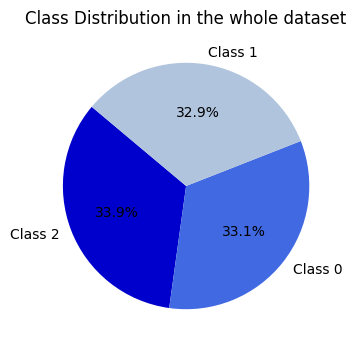

In [ ]:
# Calculating class percentages from the whole dataset
class_counts = data[21].value_counts()
class_percentages = class_counts / len(data) * 100

class_labels = ['Class ' + str(label) for label in class_percentages.index]

# Plotting the pie chart
plt.figure(figsize=(4, 4))
plt.pie(class_percentages, labels=class_labels, autopct='%1.1f%%', startangle=140, colors=['mediumblue', 'royalblue', 'lightsteelblue'])
plt.title('Class Distribution in the whole dataset')
plt.show()

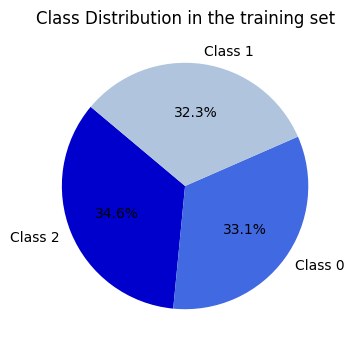

In [ ]:
# Calculate class percentages from the training dataset
class_counts = train_set[21].value_counts()
class_percentages = class_counts / len(data) * 100

class_labels = ['Class ' + str(label) for label in class_percentages.index]

# Plot the pie chart
plt.figure(figsize=(4, 4))
plt.pie(class_percentages, labels=class_labels, autopct='%1.1f%%', startangle=140, colors=['mediumblue', 'royalblue', 'lightsteelblue'])
plt.title('Class Distribution in the training set')
plt.show()

**6.2. Generating artificial imbalance**

The waves' dataset is pretty balanced. We can generate artificially imbalancy in the training data to analyze its impact on the accuracy on the
1000 test waves.

Let:

a be the number of examples in training set from class 2

b be the number of examples in training set from class 1

c be number of examples in training set from class 0

In [ ]:
a = int(0.346 * len(train_set))
b = int(0.323 * len(train_set))
c = int(0.331 * len(train_set))

We want the final disribution to be 90% class 2, 5% class 1 and 5% class 0 by oversampling class 2 and not removing any examples from the other two classes. Thus, b = c = 0.05 * len(imbalanced_train_dataset)

In [ ]:
len_imbalanced_train_dataset = b / 0.05

/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (23256) in class 2 will be larger than the number of samples in the majority class (class #2 -> 1383)
  warnings.warn(


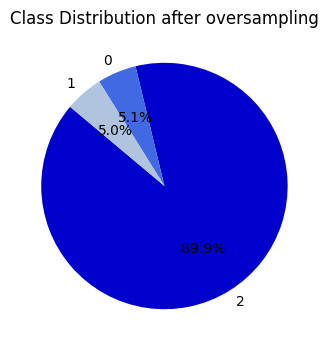

In [ ]:
# Specify the desired class distribution
desired_distribution = {0: int(0.05*len_imbalanced_train_dataset), 1: int(0.05*len_imbalanced_train_dataset), 2: int(0.90*len_imbalanced_train_dataset)}

pipeline = Pipeline([
    ('oversample', RandomOverSampler(sampling_strategy={2: desired_distribution[2]})),
])

Xtrain_imbalanced, ytrain_imbalanced = pipeline.fit_resample(Xtrain, ytrain)

train_imbalanced_dataset = pd.concat([Xtrain_imbalanced, ytrain_imbalanced], axis=1)

class_counts = train_imbalanced_dataset[21].value_counts()
class_percentages = class_counts / len(train_imbalanced_dataset) * 100

plt.figure(figsize=(4, 4))
plt.pie(class_percentages, labels=class_percentages.index, autopct='%1.1f%%', startangle=140, colors=['mediumblue', 'royalblue', 'lightsteelblue'])
plt.title('Class Distribution after oversampling')
plt.show()

**6.3. Comparing the two datasets**

In [ ]:
# Comparing the number of examples in both datasets
print("Initial number of data points in the training set is", len(train_set))
print("Number of data points in the training set after applying oversampling is", len(train_imbalanced_dataset))

Initial number of data points in the training set is  4000
Number of data points in the training set after applying oversampling is  25873


In [ ]:
X_imbalanced = train_imbalanced_dataset.drop(21, axis=1)
y_imbalanced = train_imbalanced_dataset[21]

clf_balanced = nn.KNeighborsClassifier(n_neighbors = 30)
clf_imbalanced = nn.KNeighborsClassifier(n_neighbors = 30)

clf_balanced.fit(Xtrain, ytrain)
clf_imbalanced.fit(X_imbalanced, y_imbalanced)

print('Accuracy before oversampling:', clf_balanced.score(Xtest, ytest))
print('Accuracy after oversampling:', clf_imbalanced.score(Xtest, ytest))

Accuracy before oversampling: 0.858
Accuracy after oversampling: 0.728


The accuracy values achieved by applying a k-NN model on the test set with parameters k = 30 and p = 2 indicate a decline in performance, with a reduction of 12.7% in accuracy following the oversampling of class 2.

**6.4. Tuning k with respect to the F-measure and comparing the performance with the accuracy**

In imbalanced settings, relying solely on accuracy as an
evaluation metric may be misleading. In scenarios where
one class vastly outnumbers the others, a model that predicts
the majority class most of the time can achieve high
accuracy without effectively addressing the minority classes.
Therefore, in imbalanced settings, it is essential to consider
alternative evaluation metrics such as F1-score.

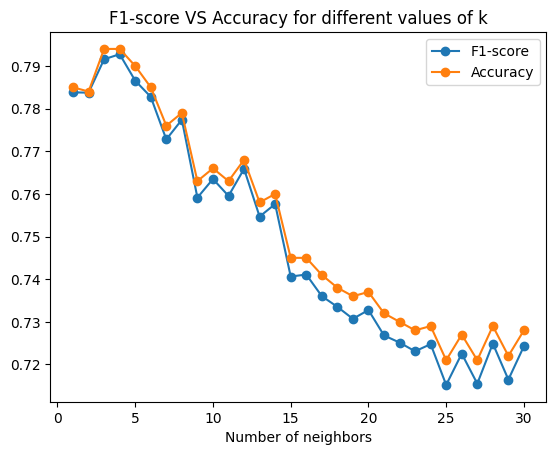

In [ ]:
f1_list=[]
accuracies=[]
k_list=[]
for k in range(1,31):
    clf = nn.KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_imbalanced,y_imbalanced)
    pred = clf.predict(Xtest)
    f1score = f1_score(ytest,pred,average='macro')
    accuracy = clf.score(Xtest,ytest)
    f1_list.append(f1score)
    accuracies.append(accuracy)
    k_list.append(k)

plt.plot(k_list, f1_list, marker = 'o', label = "F1-score")
plt.plot(k_list, accuracies, marker = 'o', label = "Accuracy")

plt.legend()
plt.xlabel("Number of neighbors")

plt.title("F1-score VS Accuracy for different values of k")
plt.show()


As shown in the plot, the k value that gives the best tradeoff
between precision and recall according to the F-measure
is k = 4. The decreasing trend in both accuracy and F1-score
after the optimal k suggests that increasing the complexity
of the model (considering more neighbors) might not be
beneficial and could lead to overfitting or capturing noise in
the data.